<a href="https://colab.research.google.com/github/amiyaaden/BigData-ApacheSpark-CovidAnalysis/blob/main/NLP_BART_research_paper_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
pip install rouge

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:


import pandas as pd
from transformers import BartForConditionalGeneration, BartTokenizer, T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from rouge import Rouge
from datasets import Dataset
from google.colab import drive
from tqdm import tqdm
import torch


#Loading Dataset

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Defining input and output file paths
DATA_PATH = '/content/drive/My Drive/arXiv_dataset.csv'
OUTPUT_FILE = '/content/summarized_papers.csv'


print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
df = df[:10]

Mounted at /content/drive
Loading dataset...


In [ ]:
dataset = Dataset.from_pandas(df[['Abstract', 'Introduction', 'Conclusion']])

# Summarization Settings
Setting the parameters for the models. Keeping the number of epochs and batch size low due to computing power restrictions

In [ ]:
# Summarization settings
MAX_INPUT_LENGTH = 1024
MAX_SUMMARY_LENGTH = 150
MODEL_BEAMS = 4
BATCH_SIZE = 2
EPOCHS = 3

#Loading the Pre-trained models
- Bidirectional and Auto-Regressive Transformers
- Text-to-Text Transfer Transformer

######BART
BART utilizes a denoising autoencoder approach where it learns to generate text by reconstructing noisy inputs. This bidirectional approach allows BART to better understand the context of the entire document, which is essential for summarizing long research papers where information is spread out.
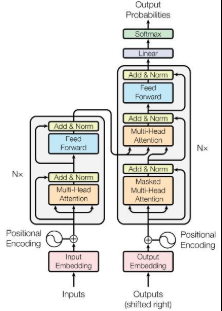

######T5
T5 is based on a unified text-to-text framework, meaning it can treat all NLP tasks (including summarization) as a text transformation problem. It converts the input (research paper) into a summary output in a consistent and flexible manner, making it ideal for tasks where the goal is to generate a summary from a detailed document.
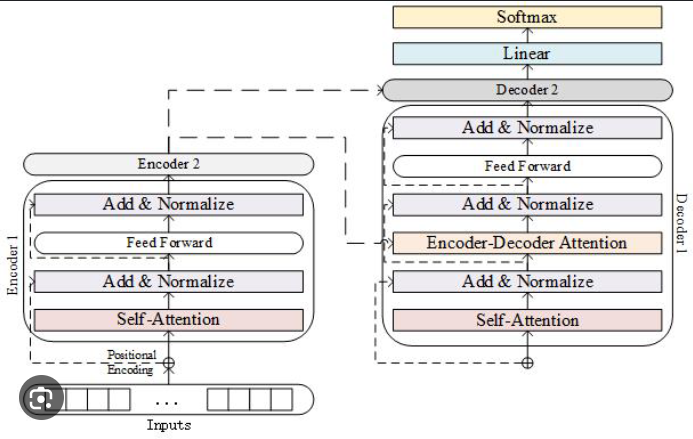

In [ ]:
print("Loading pre-trained models...")
# Loading the pre-trained BART and T5 models and their tokenizers
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
print("Models loaded successfully.")

Loading pre-trained models...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Models loaded successfully.


# Summarization Functions

In [ ]:
def summarize_bart(text):
    inputs = bart_tokenizer(text, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True)
    summary_ids = bart_model.generate(inputs['input_ids'], max_length=MAX_SUMMARY_LENGTH, num_beams=MODEL_BEAMS, early_stopping=True)
    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
def summarize_t5(text):
    inputs = t5_tokenizer("summarize: " + text, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True)
    summary_ids = t5_model.generate(inputs['input_ids'], max_length=MAX_SUMMARY_LENGTH, num_beams=MODEL_BEAMS, early_stopping=True)
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Text Processing
Contacenating the Abstract, Introduction and Conclusion columns of the dataset into a single combined text column so that the model can process on entire research paper at once

In [ ]:
def combine_text(row):
    return " ".join([str(row.get(col, "")) for col in ['Abstract', 'Introduction', 'Conclusion']])

# Evaluation
Using rouge scores to evaluate the model. Since there is no direct summary present to compare the generated text with, we will use Abstract as the reference as the abstract contains all the important information discussed in the paper

In [ ]:
def evaluate_summary(reference, generated):
    rouge = Rouge()
    try:
        scores = rouge.get_scores(generated, reference)[0]
        return {metric: scores[metric]['f'] for metric in ['rouge-1', 'rouge-2', 'rouge-l']}
    except ValueError as e:
        print(f"Error evaluating summary: {e}")
        return {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}

# Model Training

In [ ]:
def generate_summaries(df):
    bart_summaries = []
    t5_summaries = []
    rouge_scores = []

    print("Starting summarization...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        combined_text = combine_text(row)
        try:
            bart_summary = summarize_bart(combined_text)
            t5_summary = summarize_t5(combined_text)
            bart_summaries.append(bart_summary)
            t5_summaries.append(t5_summary)

            # Evaluate using ROUGE (comparing with Abstract as reference)
            rouge_scores.append(evaluate_summary(row['Abstract'], bart_summary))
        except Exception as e:
            print(f"Error generating summary: {e}")
            bart_summaries.append("Error")
            t5_summaries.append("Error")
            rouge_scores.append({'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0})

    return bart_summaries, t5_summaries, rouge_scores

In [ ]:
bart_summaries, t5_summaries, rouge_scores = generate_summaries(df)

Starting summarization...


100%|██████████| 10/10 [07:40<00:00, 46.07s/it]


# Storing Results to CSV

In [ ]:
df['Bart_Summary'] = bart_summaries
df['T5_Summary'] = t5_summaries
df['ROUGE_Scores'] = rouge_scores

In [ ]:
df.to_csv(OUTPUT_FILE, index=False)
print(f"Summarization and evaluation completed. Results saved to: {OUTPUT_FILE}")

Summarization and evaluation completed. Results saved to: /content/summarized_papers.csv


In [ ]:
from transformers import pipeline

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Input sections of a research paper
title = "The Impact of Time Series Analysis on Forecasting Methods"
abstract = "This paper explores the role of time series analysis in improving forecasting techniques across various domains such as finance, healthcare, and climate studies. By leveraging advanced models like ARIMA and machine learning, we demonstrate significant enhancements in predictive accuracy and decision-making."
introduction = "Time series analysis has been pivotal in analyzing temporal data. Its applications range from predicting stock prices to monitoring patient health metrics. Recent advancements in computational power and algorithms have expanded the scope of time series analysis, enabling real-time forecasting and anomaly detection."
conclusion = "Our study concludes that integrating time series models with domain-specific knowledge can drastically improve forecasting performance. Future research should focus on hybrid models that combine statistical and machine learning approaches to address complex datasets."

# Combine sections for summarization
full_text = f"Title: {title}\nAbstract: {abstract}\nIntroduction: {introduction}\nConclusion: {conclusion}"

# Generate summary
summary = summarizer(full_text, max_length=130, min_length=30, do_sample=False)[0]['summary_text']

# Display the result
print("Original Text:\n", full_text)
print("\nGenerated Summary:\n", summary)

Device set to use cuda:0


Original Text:
 Title: The Impact of Time Series Analysis on Forecasting Methods
Abstract: This paper explores the role of time series analysis in improving forecasting techniques across various domains such as finance, healthcare, and climate studies. By leveraging advanced models like ARIMA and machine learning, we demonstrate significant enhancements in predictive accuracy and decision-making.
Introduction: Time series analysis has been pivotal in analyzing temporal data. Its applications range from predicting stock prices to monitoring patient health metrics. Recent advancements in computational power and algorithms have expanded the scope of time series analysis, enabling real-time forecasting and anomaly detection.
Conclusion: Our study concludes that integrating time series models with domain-specific knowledge can drastically improve forecasting performance. Future research should focus on hybrid models that combine statistical and machine learning approaches to address complex